In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from uszipcode import SearchEngine
from IPython.display import Image
import time
import math

# Data Prep / Metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Linear Regression w/ l2 norm (Ridge)
from linear_reg import lr_gridsearch
from sklearn.linear_model import Ridge

# Random Forest
from random_forest import rf_train, feat_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

# Feature importance
from sklearn.inspection import permutation_importance

import joblib

# Visualization and Metrics
## Load Models

In [37]:
models = []
# Load the saved model from disk
# model_lr_old = joblib.load('Models/model_lr.joblib')
# model_rf_old = joblib.load('Models/model_rf.joblib')
model_lr = joblib.load('Models/model_lr2.joblib')
model_rf = joblib.load('Models/model_rf2.joblib')
#model_nn = joblib.load('Models/model_nn.joblib')

models = [model_lr, model_rf]
#models = [model_lr, model_rf, model_nn]

## Load Data

In [38]:
# df_X_old = pd.read_csv('.\Data\df_X_OLD.csv')
# df_y_old = pd.read_csv('.\Data\df_y.csv')
# df_old = pd.read_csv('.\Data\df_all_features.csv')
df_X = pd.read_csv('.\Data\df_X_county.csv')
df_y = pd.read_csv('.\Data\df_y_county.csv')
df = pd.read_csv('.\Data\df_all_features_county.csv')

In [39]:
df_X

,Average EV Price,New Car Average,population,household_income,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA
0,54669.0,38747.0,509844.0,167290.0,445.323695,12.66,3.378,0.0,0.0,0.0
1,54669.0,38747.0,649980.0,241889.0,821.038725,0.12,2.429,0.0,0.0,0.0
2,54669.0,38747.0,324682.0,127365.0,455.351666,12.66,3.378,0.0,0.0,0.0
3,54669.0,38747.0,69444.0,27199.0,2248.011733,0.12,2.429,0.0,0.0,0.0
4,54669.0,38747.0,715878.0,287756.0,4674.337363,0.12,2.429,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
11084,54669.0,38747.0,13588.0,5798.0,9.570523,9.53,3.908,0.0,0.0,1.0
11085,54669.0,38747.0,11906.0,4866.0,7.258144,9.53,3.908,0.0,0.0,1.0
11086,54669.0,38747.0,22121.0,9714.0,25.026666,9.53,3.908,0.0,0.0,1.0
11087,54669.0,38747.0,19702.0,6035.0,10.708173,9.52,3.908,0.0,0.0,1.0


## Visualize By County

In [40]:
X = df_X.to_numpy()
y = df_y.to_numpy()

# only predict PHEV
y = y[:,0]

# split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# standardize X
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# extract list of feature names
features = df_X.columns.tolist()



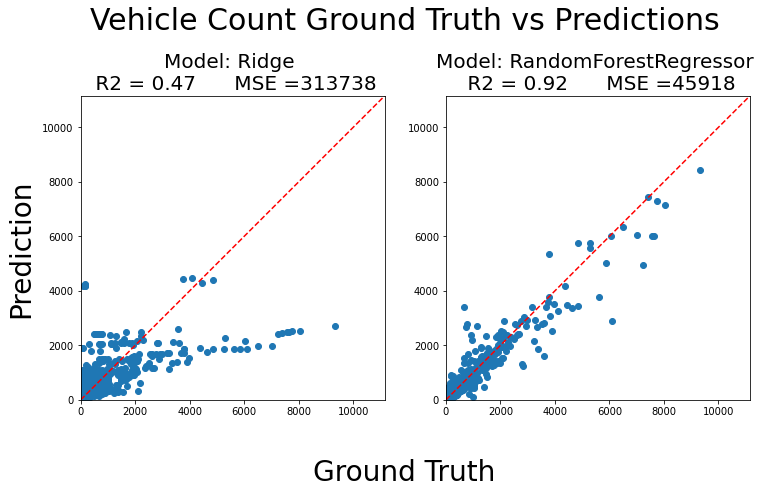

In [42]:
# Axis limits
x_min = 0
x_max = df_y['PHEV'].max()+500

# Define the number of rows and columns of subplots
num_cols = 2
num_rows = math.ceil(len(models)/num_cols)

# Create a figure and a grid of subplots with 2 columns
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 7))

# Flatten the axis array to simplify indexing
ax = ax.flatten()

for i, model in enumerate(models):
    y_hat = model.predict(X_test)

    ax[i].scatter(y_test,y_hat)

    # Add the red reference line
    
    ax[i].plot([x_min, x_max], [x_min, x_max], 'r--')

    # Set the axis limits to be the same for both x and y
    ax[i].set_xlim(x_min, x_max)
    ax[i].set_ylim(x_min, x_max)

    # Set the aspect ratio to be equal
    ax[i].set_aspect('equal', adjustable='box')

    # Get model type
    model_type = str(type(model))
    model_type = model_type.split(".")[-1]
    model_type = model_type[:-2]

    # calc R2 score
    # Compute the R-squared score
    r2 = r2_score(y_test, y_hat)
    mse = mean_squared_error(y_test, y_hat)

    # Set titles
    ax[i].set_title('Model: ' + model_type + ' \n R2 = ' + str(round(r2,2)) + 
                    '      MSE =' + str(int(mse)), fontsize=20)

# Add a common x-axis label
fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=28)

# Add a common y-axis label
fig.text(0.04, 0.5, 'Prediction', va='center', rotation='vertical', fontsize=28)

# Add a title to the entire plot
fig.suptitle('Vehicle Count Ground Truth vs Predictions', fontsize=30)

# Display the plot
plt.show()

# Percent Error by County
To Be Exported to Tableau


In [ ]:
models = [model_rf]
#models = [model_rf, model_nn]

In [33]:
df

,Registration Date,County,PHEV,Average EV Price,New Car Average,population,household_income,state,POPDEN_COU,Electricity Price,Gas Price,NY,TX,WA,Unix Time,fips,BEV
0,2017-01-01,Adams County,22.0,54669.0,38747.0,509844.0,167290.0,CO,445.323695,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8001,24.0
1,2017-01-01,Arapahoe County,61.0,54669.0,38747.0,649980.0,241889.0,CO,821.038725,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8005,65.0
2,2017-01-01,Boulder County,63.0,54669.0,38747.0,324682.0,127365.0,CO,455.351666,12.66,3.378,0.0,0.0,0.0,1.483229e+09,8013,167.0
3,2017-01-01,Broomfield County,7.0,54669.0,38747.0,69444.0,27199.0,CO,2248.011733,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8014,14.0
4,2017-01-01,Denver County,56.0,54669.0,38747.0,715878.0,287756.0,CO,4674.337363,0.12,2.429,0.0,0.0,0.0,1.483229e+09,8031,94.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11084,2018-10-01,Pend Oreille County,0.0,54669.0,38747.0,13588.0,5798.0,WA,9.570523,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53051,2.0
11085,2018-10-01,Skamania County,0.0,54669.0,38747.0,11906.0,4866.0,WA,7.258144,9.53,3.908,0.0,0.0,1.0,1.538352e+09,53059,6.0
11086,2018-11-01,Pacific County,0.0,54669.0,38747.0,22121.0,9714.0,WA,25.026666,9.53,3.908,0.0,0.0,1.0,1.541030e+09,53049,2.0
11087,2019-01-01,Adams County,0.0,54669.0,38747.0,19702.0,6035.0,WA,10.708173,9.52,3.908,0.0,0.0,1.0,1.546301e+09,53001,1.0


In [36]:
df_y

,Vehicle Count
0,24
1,66
2,170
3,15
4,95
...,...
17001,84
17002,6
17003,35
17004,5


In [ ]:
df_exp = df[['Registration Date', 'County', 'state', 'PHEV']]
for i, model in enumerate(models):
    

# Fix Vehicle Count per Month

In [ ]:
# convert the Unix timestamps to datetime format
df_X['Datetime'] = pd.to_datetime(df_X['Unix Time'], unit='s')

# format the datetime column as month-day-year
df_X['Date'] = df_X['Datetime'].dt.strftime('%m-%d-%Y')

xplt = df_X['Date']
yplt = df_y['Vehicle Count']

plt.plot(xplt,yplt, label='GT')
X_all = scaler.transform(X)
for model in models:
    y_hat_plt = []
    y_hat = model.predict(X_all)
    # for group in groups:
    #     datetime, indices = group
    #     y_hat_plt.append(sum(y_hat[indices]))
    model_type = str(type(model))
    model_type = model_type.split(".")[-1]
    model_type = model_type[:-2]
    plt.plot(xplt,y_hat_plt, label=model_type)

plt.legend()
plt.show()

In [ ]:
df_X['State'] = df['State']

# groupby and apply a lambda function to create a list of tuples where each tuple contains the group value and a list of indices for each item in the group
groups = df_X.groupby(['Datetime', 'State'])['Average EV Price'].apply(lambda x: ((x.name[0], x.name[1]), x.index.tolist())).tolist()

states = ['TX', 'NY', 'CO', 'WA']

for state in states:
    xplt = [x[0][0] for x in groups if x[0][1] == state]
    indices = [x[1] for x in groups if x[0][1] == state]
    yplt = []
    for idx in indices:
        yplt.append(sum(df_y.loc[idx, 'Vehicle Count']))

    plt.plot(xplt,yplt, label=state)
    
plt.legend()
plt.show()

yplt = []
for group in groups:
    datetime, indices = group
    yplt.append(sum(df_y.loc[indices, 'Vehicle Count']))

y_hat_plt = []
y_hat = model_rf.predict(X_all)
for group in groups:
    datetime, indices = group
    y_hat_plt.append(sum(y_hat[indices]))

plt.plot(xplt,y_hat_plt, label=model_type)

# OLD by ZIP

In [ ]:
# X = df_X_old.to_numpy()
# y = df_y_old.to_numpy()

# # split train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# # standardize X
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# # extract list of feature names
# features = df_X_old.columns.tolist()

# models = [model_lr_old, model_rf_old]
# df_y_old['Vehicle Count'].max()
# # Axis limits
# x_min = 0
# x_max = df_y_old['Vehicle Count'].max()

# # Define the number of rows and columns of subplots
# num_cols = 2
# num_rows = math.ceil(len(models)/num_cols)

# # Create a figure and a grid of subplots with 2 columns
# fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 10))

# # Flatten the axis array to simplify indexing
# ax = ax.flatten()

# for i, model in enumerate(models):
#     y_hat = model.predict(X_test)

#     ax[i].scatter(y_test,y_hat)

#     # Add the red reference line
    
#     ax[i].plot([x_min, x_max], [x_min, x_max], 'r--')

#     # Set the axis limits to be the same for both x and y
#     ax[i].set_xlim(x_min, x_max)
#     ax[i].set_ylim(x_min, x_max)

#     # Set the aspect ratio to be equal
#     ax[i].set_aspect('equal', adjustable='box')

#     # Get model type
#     model_type = str(type(model))
#     model_type = model_type.split(".")[-1]
#     model_type = model_type[:-2]

#     # calc R2 score
#     # Compute the R-squared score
#     r2 = r2_score(y_test, y_hat)
#     mse = mean_squared_error(y_test, y_hat)

#     # Set titles
#     ax[i].set_title('Model: ' + model_type + ' \n R2 = ' + str(round(r2,2)) + 
#                     ' \n MSE =' + str(int(mse)))

# # Add a common x-axis label
# fig.text(0.5, 0.04, 'Ground Truth', ha='center', fontsize=14)

# # Add a common y-axis label
# fig.text(0.04, 0.5, 'Prediction', va='center', rotation='vertical', fontsize=14)

# # Add a title to the entire plot
# fig.suptitle('Vehicle Count Ground Truth vs Predictions for Test Set', fontsize=16)

# # Display the plot
# plt.show()